In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
import yfinance as yf

In [16]:
import math
def sigmoid(x):
    sig = 1 / (1 + math.exp(-x))
    return sig

In [17]:
def SRN_garch(alpha, beta, gamma0, gamma1, v1, v2, nun_lin_func, returns):
    iT = len(returns)
    sigma_2 = np.zeros(iT)
    w = np.zeros(iT)
    h = np.zeros(iT)
    for i in range(iT):
        if i == 0:
            sigma_2[i] = 0.1/(1- alpha - beta)
            h[i] = 0.1/(1- alpha - beta)
            w[i] = 0.1/(1- alpha - beta)
        else:
            h[i] = nun_lin_func(v1 * returns[i-1] + v2 * sigma_2[i-1])
            w[i] = gamma0 + gamma1 * h[i]
            sigma_2[i] = w[i] + alpha * returns[i-1]**2 + beta * sigma_2[i-1]
    return sigma_2, w, h

In [18]:
def SRN_garch_loglike(start_v, nun_lin_func, returns):
    iT = len(returns)
    alpha = start_v[0]
    beta = start_v[1]
    gamma0 = start_v[2]
    gamma1 = start_v[3]
    v1 = start_v[4]
    v2 = start_v[5]
    
    sigma_2 = SRN_garch(alpha, beta, gamma0, gamma1, v1, v2, nun_lin_func, returns)[0]
    LogL = - np.sum(-np.log(sigma_2) -  returns**2/sigma_2)
    return LogL

In [19]:
data = yf.download("^GSPC", start="2012-01-01", end="2020-01-01")

data['pct_change'] = data.Open.pct_change()

data['log_ret'] = np.log(data.Open) - np.log(data.Open.shift(1))


data['log_ret * 100'] = data['log_ret'] * 100

[*********************100%***********************]  1 of 1 completed


In [20]:
returns = data['log_ret * 100'].values[1:]

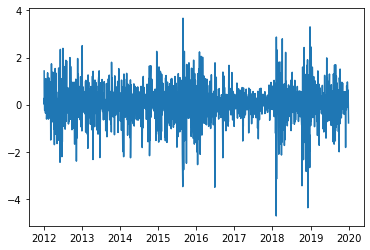

In [21]:
plt.plot(data['log_ret * 100'])

In [22]:
cons = ({"type": "ineq", "func" : lambda x: np.array(x)})
vP0 = (0.1, 0.25, 0.52, 0.1, 0.1, 0.2)
my_bounds = ((0.0001,1), (0.0001,1), (0.0001, 3),(0.00001,3),(-100,100),(-100,100))

res = opt.minimize(SRN_garch_loglike, vP0, args = (sigmoid, returns),
                  bounds = my_bounds,
                   method = "Nelder-Mead",
                  options = {"disp": True, "maxiter": 500000})

C:\Users\mobem\AppData\Local\Temp\ipykernel_5676\1449779220.py:11: RuntimeWarning: invalid value encountered in log
  LogL = - np.sum(-np.log(sigma_2) -  returns**2/sigma_2)


Optimization terminated successfully.
         Current function value: 440.230301
         Iterations: 1541
         Function evaluations: 2345


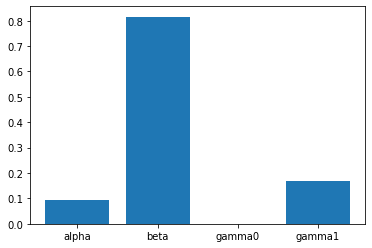

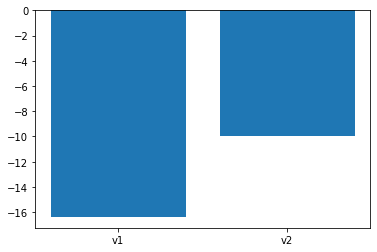

In [23]:
par_names = ["alpha", "beta", "gamma0", "gamma1", "v1", "v2"]

plt.bar(par_names[:4], res.x[:4])
plt.show()

plt.bar(par_names[4:], res.x[4:])
plt.show()

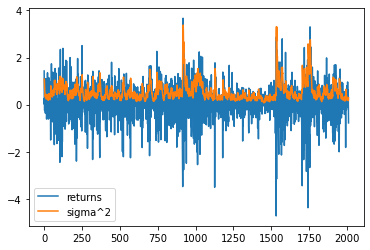

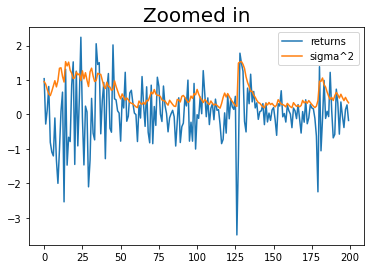

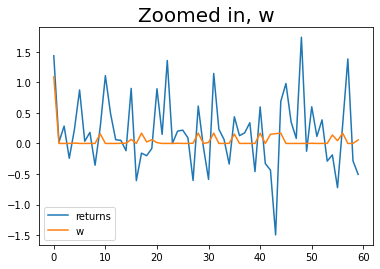

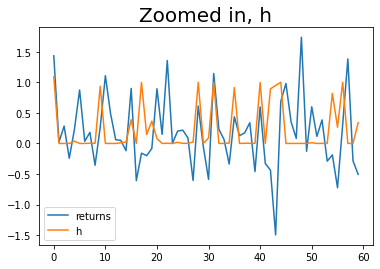

In [24]:
plt.plot(returns, label = "returns")
plt.plot(SRN_garch(res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5], sigmoid, returns)[0], label = "sigma^2")
plt.legend()
plt.show()

plt.plot(returns[1000:1200], label = "returns")
plt.plot(SRN_garch(res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5], sigmoid, returns)[0][1000:1200], label = "sigma^2")
plt.title("Zoomed in", size = 20)
plt.legend()
plt.show()

plt.plot(returns[:60], label = "returns")
plt.plot(SRN_garch(res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5], sigmoid, returns)[1][:60], label = "w")
plt.title("Zoomed in, w", size = 20)
plt.legend()
plt.show()

plt.plot(returns[:60], label = "returns")
plt.plot(SRN_garch(res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5], sigmoid, returns)[2][:60], label = "h")
plt.title("Zoomed in, h", size = 20)
plt.legend()
plt.show()